<a href="https://colab.research.google.com/github/RenataReisgomes/Modulador_e_demodulador/blob/main/TCC_GRU_CV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
import seaborn as sns
import imblearn
import tensorflow as tf
import random
import plotly.graph_objects as go
import plotly.express as px
from tensorflow.keras.layers import GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
import plotly.figure_factory as ff
import matplotlib.colors as mcolors
from PIL import ImageFont
from collections import defaultdict
from tensorflow.keras.regularizers import l2
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import metrics
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, RocCurveDisplay, det_curve, auc)
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.datasets import make_blobs
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from imblearn.over_sampling import SMOTE
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from google.colab import drive
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import glob
import os

# **Visualização dos Dados**

In [ ]:
drive.mount('/content/drive')
#tf.config.experimental_run_functions_eagerly(True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
paths = [
    ("/content/drive/My Drive/dataset/dataset_original/Dataset/bus", "bus"),
    ("/content/drive/My Drive/dataset/dataset_original/Dataset/car", "car"),
    ("/content/drive/My Drive/dataset/dataset_original/Dataset/pedestrian", "pedestrian"),
    ("/content/drive/My Drive/dataset/dataset_original/Dataset/train", "train")
]
filenames = []
for path, label in paths:
    filenames.extend([(filename, label) for filename in glob.glob(os.path.join(path, "*.csv"))])

Lis = []
for filename, label in filenames:
    df = pd.read_csv(filename, index_col=None, header=0)
    df['path'] = label
    Lis.append(df)

LTE_data = pd.concat(Lis, axis=0, ignore_index=True)
LTE_data

,Timestamp,Longitude,Latitude,Speed,Operatorname,CellID,NetworkMode,RSRP,RSRQ,SNR,...,State,NRxRSRP,NRxRSRQ,ServingCell_Lon,ServingCell_Lat,ServingCell_Distance,path,Label,Handover PingPong,Handover Ok
0,2018.01.26_11.26.26,-8.456939,51.888359,2,A,1,LTE,-103,-10,2.0,...,D,-103.0,-11.0,-8.446375,51.878637,1301.6800000000001,bus,NaN,NaN,NaN
1,2018.01.26_11.26.26,-8.456939,51.888359,2,A,1,LTE,-106,-11,3.0,...,D,-104.0,-11.0,-8.446375,51.878637,1301.6800000000001,bus,NaN,NaN,NaN
2,2018.01.26_11.26.26,-8.456758,51.888280,0,A,1,LTE,-106,-11,3.0,...,D,-104.0,-11.0,-8.446375,51.878637,1287.48,bus,NaN,NaN,NaN
3,2018.01.26_11.26.28,-8.456758,51.888280,0,A,1,LTE,-106,-11,3.0,...,D,-104.0,-11.0,-8.446375,51.878637,1287.48,bus,NaN,NaN,NaN
4,2018.01.26_11.26.29,-8.456758,51.888280,0,A,1,LTE,-107,-11,3.0,...,D,-105.0,-14.0,-8.446375,51.878637,1287.48,bus,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159246,2018.02.02_12.22.50,-9.501166,52.059406,5,B,3,LTE,-100,-11,7.0,...,D,-103.0,-15.0,-9.568692,51.987705,9214.7900000000009,train,NaN,NaN,NaN
159247,2018.02.02_12.22.51,-9.501166,52.059406,5,B,3,LTE,-100,-11,7.0,...,D,-103.0,-15.0,-9.568692,51.987705,9214.7900000000009,train,NaN,NaN,NaN
159248,2018.02.02_12.22.52,-9.501166,52.059406,5,B,3,LTE,-100,-11,7.0,...,D,-103.0,-15.0,-9.568692,51.987705,9214.7900000000009,train,NaN,NaN,NaN
159249,2018.02.02_12.22.53,-9.501166,52.059406,5,B,3,LTE,-100,-11,7.0,...,D,-103.0,-15.0,-9.568692,51.987705,9214.7900000000009,train,NaN,NaN,NaN


In [ ]:
##Plotando a rede em que o dispositivo passou mais tempo conectado
#fig = px.histogram(data_frame= LTE_data['NetworkMode'])
#fig.update_layout(
#    xaxis_title="Tecnologia de Rádio",
#    yaxis_title="Tempo(s)",
#    legend_title="Legenda",
#    width = 900,
#    height= 500
#)
#fig.show()

In [ ]:

#columns_to_exclude = ['Label', 'Handover PingPong', 'Handover Ok']
#df = LTE_data.drop(columns=columns_to_exclude)
#nan_counts = df.isna().sum()
# Criar o gráfico de barras
#plt.figure(figsize=(10, 6))
#nan_counts.plot(kind='bar')
#plt.xlabel('Colunas')
#plt.ylabel('Número de Células NaN')
#plt.xticks(rotation=90)
#plt.show()

In [ ]:

#fig=px.line(x=LTE_data['Latitude'], y=LTE_data['Longitude'])


#fig.update_traces(name='Trajetória do UE', showlegend=True)

#fig.update_layout(
#    xaxis_title="Latitude",
#    yaxis_title="Longitude",
#    legend_title="Legenda",
#    font=dict(color="black"),
#    width = 900,
#    height= 500
#)

#fig.add_trace(go.Scatter(x=LTE_data['ServingCell_Lat'], y=LTE_data['ServingCell_Lon'],
#                    mode='markers',
#                    name='Estações Rádio Base'))
#fig.show()


In [ ]:
datagru = pd.read_csv('/content/drive/My Drive/dataset/Dataset_10s/Dados_de_teste _GRU.csv')
dataho = pd.read_csv('/content/drive/My Drive/dataset/Dataset_10s/Resumo_dataset_Oficial.csv')

In [ ]:
hook = dataho['Handover'] - dataho['Label 0']
hofail = dataho['Label 0']
sheet = dataho['Sheet']
noneAction = dataho['Label 1 '] - dataho['Handover']

datas = [np.sum(hook),np.sum(hofail), np.sum(noneAction)]
names = ['Handovers necessários', 'Handovers desnecessários', 'Nenhum evento necessário']

fig = px.pie(values=datas, names=names) 
fig.update_layout(
    width = 900,
    height= 500
)

fig.show()

# Importando o dataset

In [ ]:
label = pd.read_csv('/content/drive/My Drive/dataset/Dataset_10s/label_complete_rev2.csv')
data = pd.read_csv('/content/drive/My Drive/dataset/Dataset_10s/data_complete_rev3.csv',index_col='Timestamp')

[]

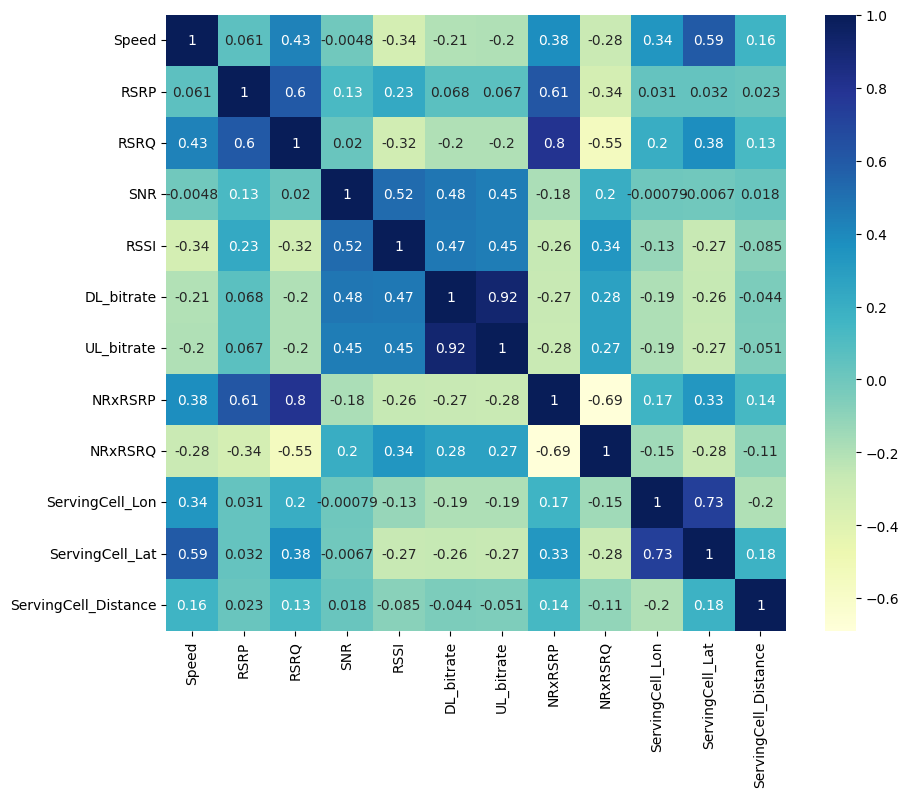

In [ ]:
#Matriz de correlação dos dados

corr_matrix = data.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu')
plt.plot()

Text(0.5, 0, 'Rótulos')

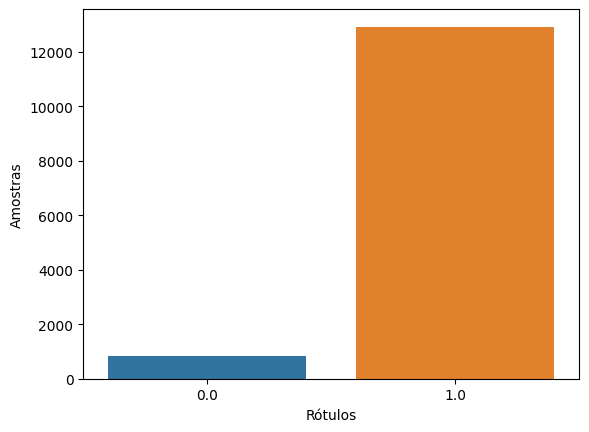

In [ ]:
sns.countplot(data=label, x="Label")
plt.ylabel('Amostras')
plt.xlabel('Rótulos')


# Normalizar os dados

In [ ]:
#Normalizando os dados
scaler = StandardScaler()


In [ ]:
#scaled_data = scaler.fit_transform(data) 
scaled_data = scaler.fit_transform(data)


In [ ]:
scaled_data.shape


(137580, 12)

# One-step Cross Validation e definição de dados de treino e teste:






In [ ]:
# Transformando os dados para bidimencional por conta do formato da entrada na função SMOTE (376, 30*6)
scaled_data3d = np.reshape(scaled_data,(13758,10,12))
scaled_data2d = np.reshape(scaled_data3d,(13758,120))

In [ ]:

n_folds = 10
tscv = TimeSeriesSplit(n_splits=n_folds)

for fold, (train_index, test_index) in enumerate(tscv.split(scaled_data2d)):
    print("Fold: {}".format(fold))
    print("TRAIN indices:", train_index, "\n", "TEST indices:", test_index)
    print("\n")
    data_train, data_test = scaled_data2d[train_index], scaled_data2d[test_index]
    label_train, label_test = label.to_numpy()[train_index], label.to_numpy()[test_index]

Fold: 0
TRAIN indices: [   0    1    2 ... 1255 1256 1257] 
 TEST indices: [1258 1259 1260 ... 2505 2506 2507]


Fold: 1
TRAIN indices: [   0    1    2 ... 2505 2506 2507] 
 TEST indices: [2508 2509 2510 ... 3755 3756 3757]


Fold: 2
TRAIN indices: [   0    1    2 ... 3755 3756 3757] 
 TEST indices: [3758 3759 3760 ... 5005 5006 5007]


Fold: 3
TRAIN indices: [   0    1    2 ... 5005 5006 5007] 
 TEST indices: [5008 5009 5010 ... 6255 6256 6257]


Fold: 4
TRAIN indices: [   0    1    2 ... 6255 6256 6257] 
 TEST indices: [6258 6259 6260 ... 7505 7506 7507]


Fold: 5
TRAIN indices: [   0    1    2 ... 7505 7506 7507] 
 TEST indices: [7508 7509 7510 ... 8755 8756 8757]


Fold: 6
TRAIN indices: [   0    1    2 ... 8755 8756 8757] 
 TEST indices: [ 8758  8759  8760 ... 10005 10006 10007]


Fold: 7
TRAIN indices: [    0     1     2 ... 10005 10006 10007] 
 TEST indices: [10008 10009 10010 ... 11255 11256 11257]


Fold: 8
TRAIN indices: [    0     1     2 ... 11255 11256 11257] 
 TEST indice

# Técnica SMOTE para oversampling 

In [ ]:
#Aplicando a Técnica de SMOTE nos dados de treino

smt = SMOTE(sampling_strategy= 'minority')
data_trainsmt, label_trainsmt = smt.fit_resample(data_train,label_train)

Text(0.5, 0, 'Rótulos')

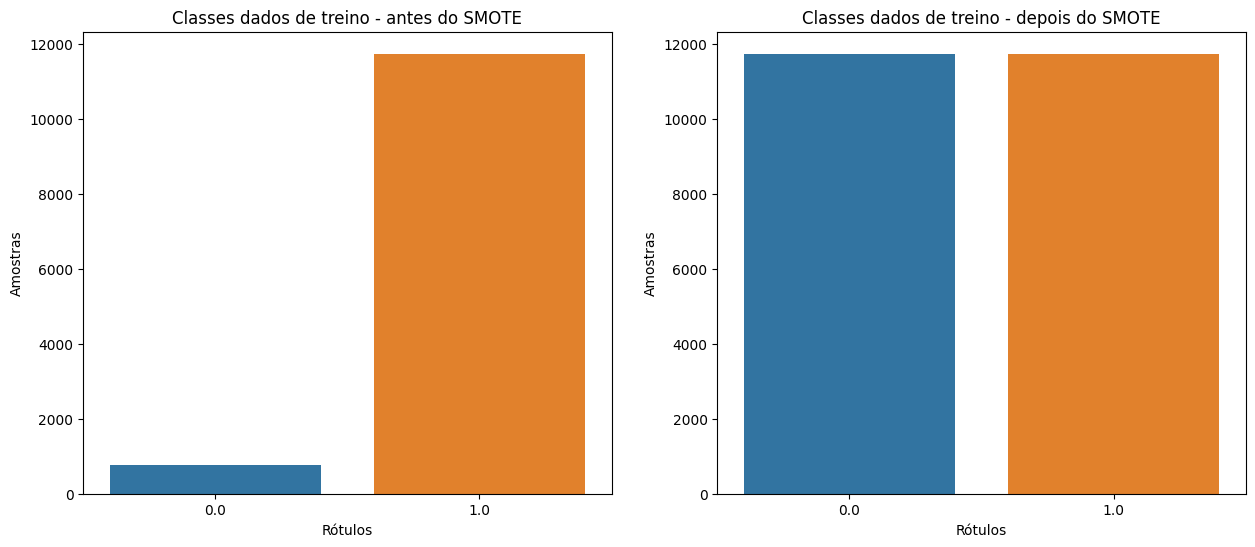

In [ ]:
#Comparação das classes

label_traindf = pd.DataFrame(data=label_train, columns=["Label"])
label_smtdf = pd.DataFrame(data= label_trainsmt, columns=["Label"])

plt.figure(figsize = (15, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=label_traindf, x="Label")
plt.title('Classes dados de treino - antes do SMOTE')
plt.ylabel('Amostras')
plt.xlabel('Rótulos')
plt.subplot(1, 2, 2)
sns.countplot(data=label_smtdf, x="Label")
plt.title('Classes dados de treino - depois do SMOTE')
plt.ylabel('Amostras')
plt.xlabel('Rótulos')

In [ ]:
data_trainsmt.shape

(23498, 120)

In [ ]:
#Mudando a dimensão das entradas após o oversampling
data_train3d = np.reshape(data_trainsmt,(23498,10,12))
label_test3d = np.reshape(label_test,(1250,1))
data_test3d = np.reshape(data_test,(1250,10,12))
data_test3d.shape

(1250, 10, 12)

In [ ]:
#define model 
model = Sequential()
model.add(GRU(8, activation ='tanh', input_shape=(10, 12), kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
model.add(Dense(1, activation = "sigmoid"))
model.compile(optimizer= 'Adam', loss='binary_crossentropy', metrics =['accuracy'])

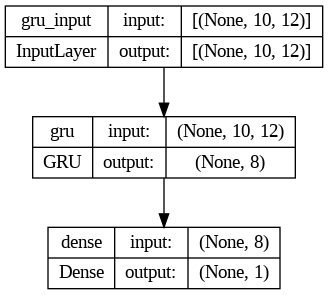

In [ ]:
plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 8)                 528       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


# Treino e Validação

In [ ]:
early_stop =EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(data_train3d, label_trainsmt, validation_data=(data_train3d,label_trainsmt),  batch_size=64 ,  epochs=150, callbacks=[early_stop])
#model.fit(data_train3d, label_trainsmt, validation_data=(data_train3d,label_trainsmt),  batch_size=64 ,  epochs=150)

Epoch 1/150
368/368 [==============================] - 17s 27ms/step - loss: 0.7281 - accuracy: 0.6423 - val_loss: 0.6451 - val_accuracy: 0.6619
Epoch 2/150
368/368 [==============================] - 8s 22ms/step - loss: 0.6284 - accuracy: 0.6655 - val_loss: 0.6160 - val_accuracy: 0.6711
Epoch 3/150
368/368 [==============================] - 6s 16ms/step - loss: 0.6094 - accuracy: 0.6780 - val_loss: 0.6026 - val_accuracy: 0.6811
Epoch 4/150
368/368 [==============================] - 4s 11ms/step - loss: 0.5982 - accuracy: 0.6958 - val_loss: 0.5917 - val_accuracy: 0.7018
Epoch 5/150
368/368 [==============================] - 4s 12ms/step - loss: 0.5878 - accuracy: 0.7099 - val_loss: 0.5801 - val_accuracy: 0.7168
Epoch 6/150
368/368 [==============================] - 5s 14ms/step - loss: 0.5781 - accuracy: 0.7208 - val_loss: 0.5757 - val_accuracy: 0.7276
Epoch 7/150
368/368 [==============================] - 4s 12ms/step - loss: 0.5714 - accuracy: 0.7285 - val_loss: 0.5654 - val_accuracy

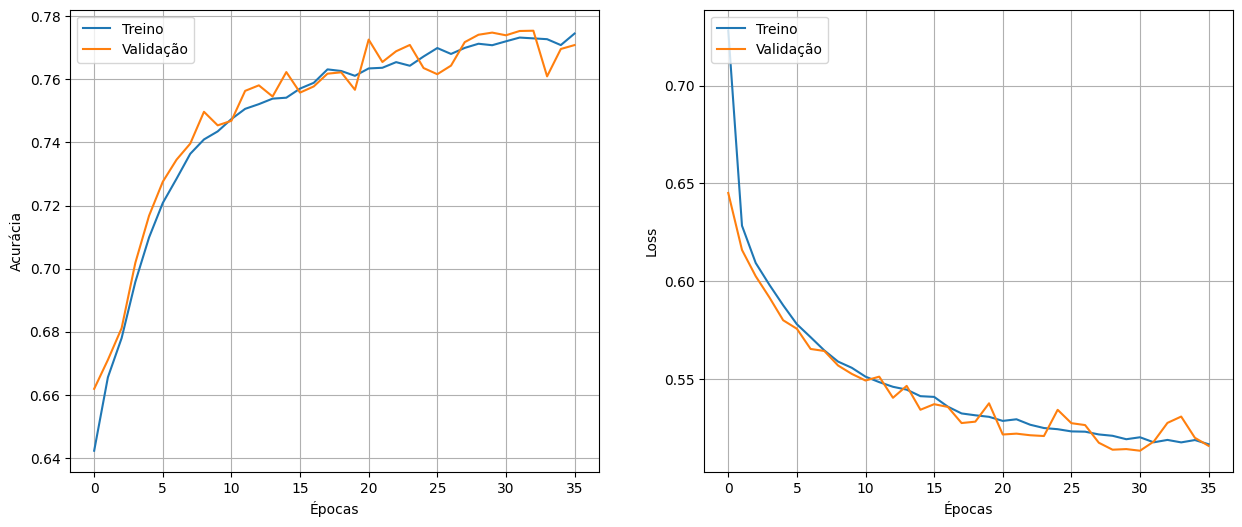

In [ ]:
plt.figure(figsize = (15, 6))


plt.subplot(1, 2, 1)
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.ylabel('Acurácia')
plt.xlabel('Épocas')
plt.grid()
plt.legend(['Treino','Validação'], loc='upper left')


plt.subplot(1, 2, 2)
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Épocas')
plt.grid()
plt.legend(['Treino','Validação'], loc='upper left')

Text(0.5, 1.0, 'Classes dados de teste')

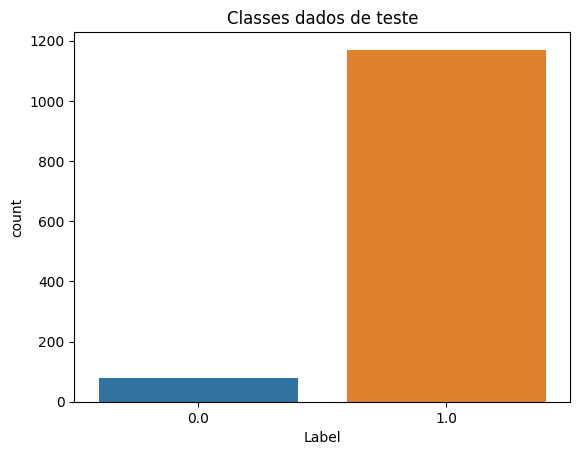

In [ ]:
#Visualização dos dados de test
data_true = pd.DataFrame(data= label_test3d, columns=["Label"])
sns.countplot(data=data_true, x="Label")
plt.title('Classes dados de teste')


In [ ]:

loss, accuracy = model.evaluate(data_test3d, label_test3d)
pred =  model.predict(data_test3d)
# A saida está no formato de probabilidades, é necessário transformar novamente para as classes
pred_class = np.where(pred >= 0.5, 1, 0)

precision = precision_score(label_test3d, pred_class)
recall = recall_score(label_test3d, pred_class)
f1score = f1_score(label_test3d, pred_class)

data_pred = pd.DataFrame(data= pred, columns=["Label"])
data_true = pd.DataFrame(data= label_test3d, columns=["Label"])

variance = np.var(label_test3d - pred_class)
bias = np.mean(label_test3d - pred_class)

print("Test Loss:", loss)
print("Test Accuracy:", accuracy)
print("Test Precision:", precision)
print("Test Recall:", recall)
print("Test F1-score:", f1score)
print("Variance:", variance)
print("Bias:", bias)

40/40 [==============================] - 1s 4ms/step
Test Loss: 0.4699918329715729
Test Accuracy: 0.7767999768257141
Test Precision: 0.9597523219814241
Test Recall: 0.7948717948717948
Test F1-score: 0.8695652173913044
Variance: 0.19734336
Bias: 0.1608


# Visualização dos resultados

<Figure size 800x800 with 0 Axes>

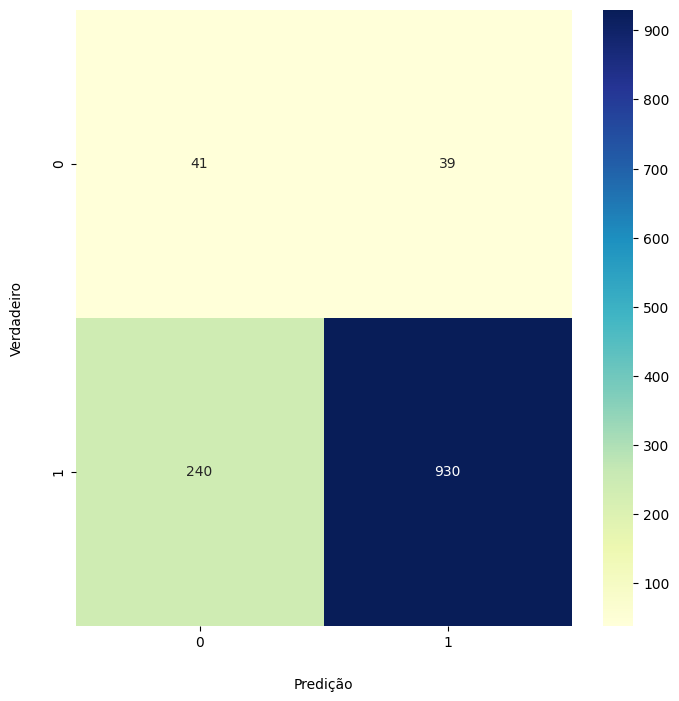

In [ ]:
#Matriz confusão
conf_matrix = confusion_matrix(label_test3d, pred_class)
plt.figure(figsize=(8,8))
#sns.set(font_scale = 1.5)

# Plotar a matriz de confusão
plt.figure(figsize=(8, 8))
ax = sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cbar=True,
    cmap='YlGnBu'
)

# Definir rótulos dos eixos
ax.set_xlabel("Predição", labelpad=20)
ax.set_ylabel("Verdadeiro", labelpad=20)

plt.show()

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(label_test3d, pred, pos_label=1)
pr, fnr, thresholds = det_curve(label_test3d,pred)
roc_auc = auc(fpr, tpr)


In [ ]:
fig = go.Figure(data=go.Scatter(x=fpr, y=tpr, mode='lines', name='ROC Curve'))

# Set labels and title
fig.update_layout(
    title='Receiver Operating Characteristic (ROC) Curve',
    xaxis=dict(title='False Positive Rate (FPR)'),
    yaxis=dict(title='True Positive Rate (TPR)'),
    width = 900,
    height= 500
)

# Add diagonal reference line
fig.add_shape(type='line', x0=0, y0=0, x1=1, y1=1, line=dict(dash='dash'), name='Random Classifier')

# Show the AUC in the legend
fig.add_trace(go.Scatter(x=[0.5], y=[0.5], mode='text', text=f'AUC = {roc_auc:.2f}', showlegend=False))

# Show the plot
fig.show()

In [ ]:
# Create a scatter plot
fig = go.Figure(data=go.Scatter(x=fpr, y=fnr, mode='markers'))

# Customize the plot
fig.update_layout(
    title='DET Curve',
    xaxis=dict(title='False Acceptance Rate (FAR)'),
    yaxis=dict(title='False Rejection Rate (FRR)'),
    width = 900,
    height= 500
)

# Show the plot
fig.show()

In [ ]:

# Dados de probabilidade e labels verdadeiras
#data_pred = pd.DataFrame(data= pred, columns=["Label"])
#data_true = pd.DataFrame(data= label_test3d, columns=["Label"])
#threshold = 0.5

# Criar array de amostras
#amostras = range(len(data_pred ))

# Plotar o scatter plot
#plt.scatter(amostras, data_pred , label='Probabilidade')
#plt.scatter(amostras, data_true, label='Label Verdadeira')
#plt.axhline(threshold, color='red', linestyle='--', label='Limiar')
#plt.xlabel('Amostras')
#plt.ylabel('Probabilidade')
#plt.title('Probabilidade por Amostra')
#plt.grid()
#plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
#plt.show()